  ## Data Bias

I examined a dataset of Wikipedia comments from Jigsaw. The dataset includes a unique comment id, text associating with the comment and labeled based on the nature of the comment. Human raters have organzied the comments into: "toxic," "severe_toxic," "obscene," "threat," "insult," and "identity_hate." I applied the Prespective API tool to analyze bias within the model.  

In [1]:
import pandas as pd
import time
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('labeled_and_scored_comments.csv')

This function makes calls to the Prespective API. I have generated my own API key below. 

In [3]:
from googleapiclient.discovery import build
import json

def get_toxicity_score(comment):
    
  API_KEY = 'XXXX' # Put your API key here
    
  client = build(
  "commentanalyzer",
  "v1alpha1",
  developerKey=API_KEY,
  discoveryServiceUrl="https://commentanalyzer.googleapis.com/$discovery/rest?version=v1alpha1",
  static_discovery=False,
  )

  analyze_request = {
  'comment': { 'text': comment },
  'requestedAttributes': {'TOXICITY': {}}
  }
    
  response = client.comments().analyze(body=analyze_request).execute()
  toxicity_score = response["attributeScores"]["TOXICITY"]["summaryScore"]["value"]
    
  return toxicity_score

In [4]:
df.head()

,id,comment_text,score,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0001ea8717f6de06,Thank you for understanding. I think very high...,0.075638,0,0,0,0,0,0
1,000247e83dcc1211,:Dear god this site is horrible.,0.450459,0,0,0,0,0,0
2,0002f87b16116a7f,"""::: Somebody will invariably try to add Relig...",0.667964,0,0,0,0,0,0
3,0003e1cccfd5a40a,""" \n\n It says it right there that it IS a typ...",0.068434,0,0,0,0,0,0
4,00059ace3e3e9a53,""" \n\n == Before adding a new product to the l...",0.151724,0,0,0,0,0,0


These are the beggining comments from the data. As shown, there are 6 categories which classify a given comment. The comments have a score 0 being no toxicity and 1 being the most toxic. 

In [5]:
df.describe()

,score,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,41338.000000,41338.000000,41338.000000,41338.000000,41338.000000,41338.000000,41338.000000
mean,0.244467,0.095384,0.009168,0.053050,0.003024,0.049809,0.009725
std,0.257221,0.293749,0.095313,0.224137,0.054907,0.217553,0.098134
min,0.000004,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.074772,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.128969,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.310894,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.998329,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [6]:
thr = [0.6, 0.7, 0.8, 0.85, 0.9, 0.95, 0.98]
toxicity = []
severe_toxicity = []

In order to calculate a threshold, I tested the comments with the following toxicity scores: .6, .7, .8, .85, .9, .95, .98. The purpose of this was to examine at what score are these comments considered toxic, and at what point at they considered severely toxic. My hypothesis is that a toxic score is considered to be above .80 and a severe toxic score is considered to be above .90. 

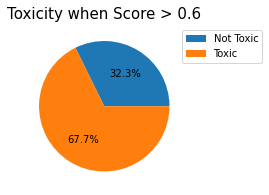

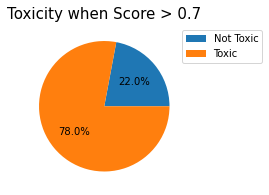

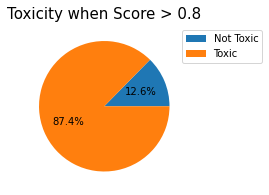

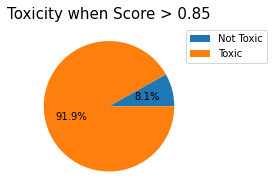

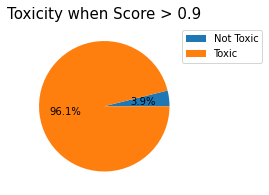

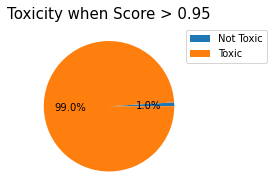

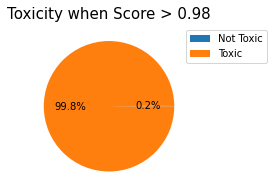

In [7]:
for t in thr:
    plt.figure(figsize=(3, 3))
    df_above_75 = df[df['score'] > t].groupby(by=['toxic']).count()['score']
    plt.pie(df_above_75, autopct='%.1f%%')
    plt.legend(['Not Toxic', 'Toxic'], bbox_to_anchor=(1.5, 1), loc="upper right")
    plt.title('Toxicity when Score > ' + str(t), size=15)
    toxicity.append(df_above_75[1] / df_above_75.sum())

I created pie chart diagrams for the toxicity when the score is above each of the given values. I calculated the percentages for what is "toxic" and what it "not toxic." I chose this method to display the correlation between scores and toxicity and get a more precise sense of where the comment is actually considered toxic. My results indicate a strong positive correlation between score and toxicity. However, they also indicate that even when there is a high score, it is not neccesarily true that the comment is toxic. This speaks to the model's accuracy with the number of false negetives. I would like to further examine specifically how toxicity and severe toxicity differ. 

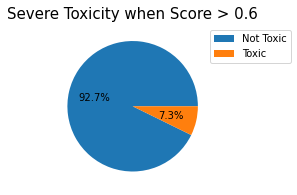

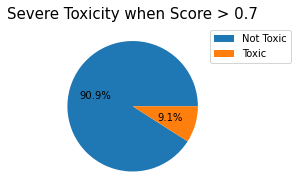

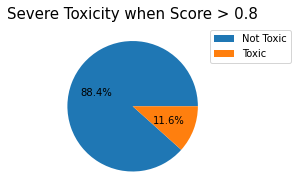

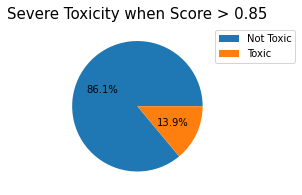

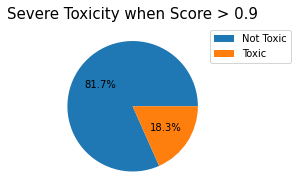

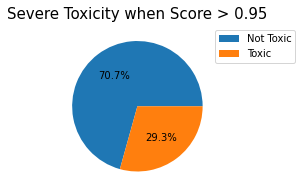

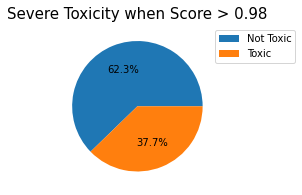

In [8]:
for t in thr:
    plt.figure(figsize=(3, 3))
    df_above_75 = df[df['score'] > t].groupby(by=['severe_toxic']).count()['score']
    plt.pie(df_above_75, autopct='%.1f%%')
    plt.legend(['Not Toxic', 'Toxic'], bbox_to_anchor=(1.5, 1), loc="upper right")
    plt.title('Severe Toxicity when Score > ' + str(t), size=15)
    severe_toxicity.append(df_above_75[1] / df_above_75.sum())

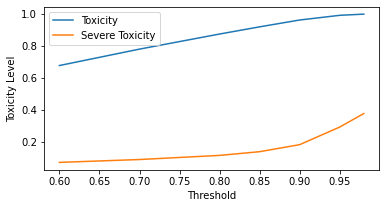

In [9]:
plt.figure(figsize=(6, 3))
plt.plot(thr, toxicity)
plt.plot(thr, severe_toxicity)
plt.xlabel('Threshold')
plt.ylabel('Toxicity Level')
plt.legend(['Toxicity', 'Severe Toxicity'])

In order to examine the relationship between "toxicity" and "severe toxicity" I compared the toxicity levels with the threshold values. I found that the "toxic" comments had a steady linear increase as the threshold values rises, while the "severe toxicity" had an exponential increase after an approximate threshold value of .90. This tells us that severe toxicity is commonly associated with a score that is greater than .90. A comment becomes toxic around .7. These results confirmed my hypothesis for severe toxicity however, for toxcity it becomes apparent with a slightly lower threshold at .7. False postive rates ceased with increasing scores, which was expected. The analysis seems to be consistent with hypotheis and expectations for false values. 

In [10]:
comment_list = ['loser', 'i hate you', 'i love you']

for comment in comment_list:
    score = get_toxicity_score(comment)
    print(comment, score)
    time.sleep(1)

HttpError: <HttpError 400 when requesting https://commentanalyzer.googleapis.com/$discovery/rest?version=v1alpha1&key=XXXX returned "API key not valid. Please pass a valid API key.". Details: "[{'@type': 'type.googleapis.com/google.rpc.ErrorInfo', 'reason': 'API_KEY_INVALID', 'domain': 'googleapis.com', 'metadata': {'service': 'commentanalyzer.googleapis.com'}}]">

Here, I tried my own comments to again check the accuracy of the model. I inputed comments that were clearly not toxic, and others that were degrading to see how different the scores would be. I see that the negetive comments are close to .7 which is consistent with the target threshold value. 